# Credit Card Fraud Detection

## Descrição do Projeto

Este projeto é modelo de Machine Learning para detecção de fraudes em transações de cartão de crédito. O objetivo é permitir que os usuários enviem dados de transações e recebam de volta a classificação correspondente, indicando se a transação é legítima ou fraudulenta.

### Etapa 1: Importação das bibliotecas necessárias

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import pickle

### Etapa 2: Carga do Dataset

In [2]:
# Informa a URL de importação do dataset
url = "./card_transdata.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Dataset muito grande, vamos usar apenas 25%
dataset = dataset.sample(frac=0.25, random_state=42)

# Mostra as primeiras linhas do dataset
dataset.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
987231,0.929509,1.296477,0.361110,0.0,0.0,0.0,1.0,0.0
79954,0.611179,0.208295,3.118884,0.0,0.0,0.0,1.0,0.0
567130,3.956062,0.529194,1.579942,1.0,0.0,0.0,0.0,0.0
500891,21.798902,0.019399,11.416909,1.0,0.0,0.0,0.0,0.0
55399,3.310635,1.707802,2.028915,1.0,0.0,0.0,0.0,0.0


### Etapa 3: Separação em Conjuntos (Holdout)

In [3]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:7]
y = array[:,7]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### Etapa 4: Criação e avaliação de modelos: linha base

KNN: 0.972130 (0.001349)
CART: 0.999915 (0.000059)
NB: 0.946065 (0.002241)
SVM: 0.937270 (0.000994)


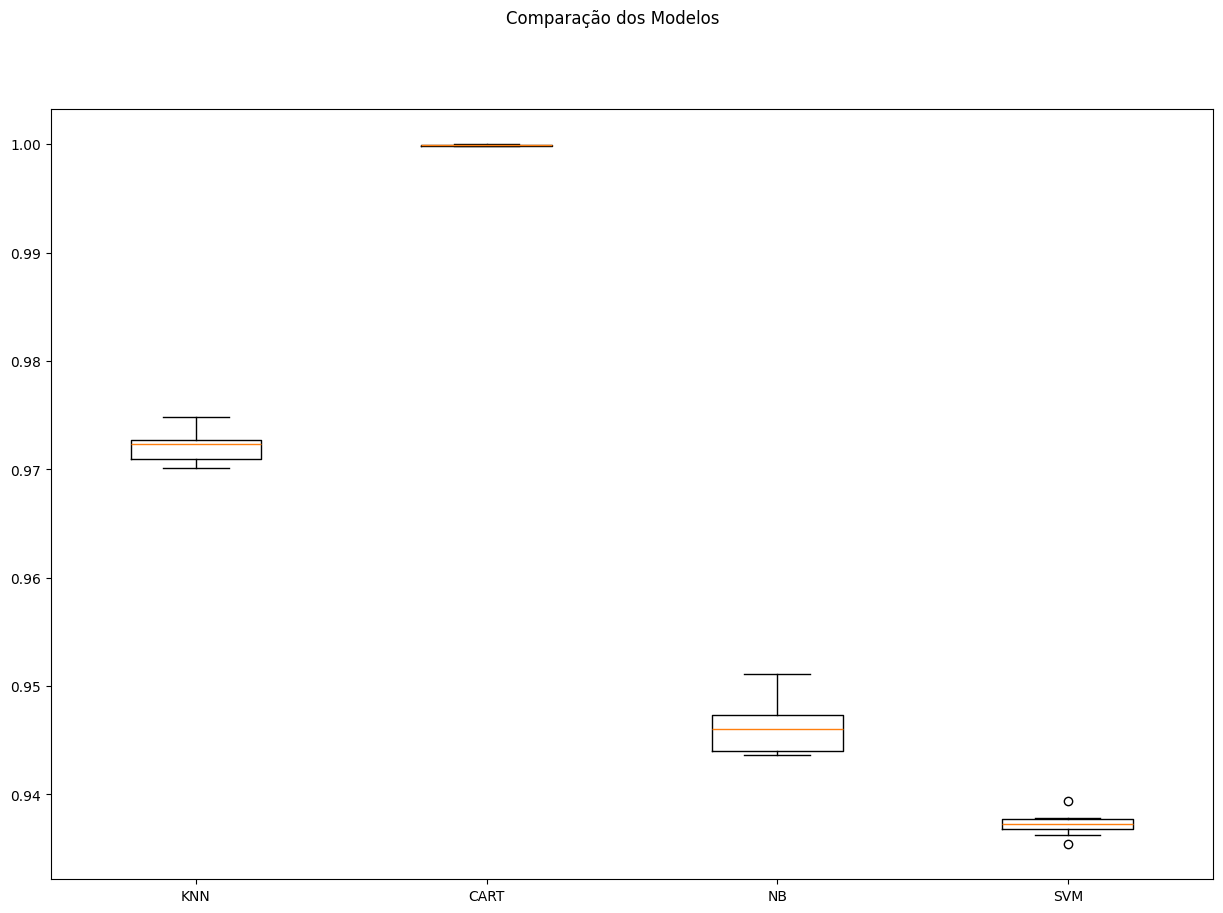

In [4]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Etapa 5: Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.972 (0.001)
CART-orig: 1.000 (0.000)
NB-orig: 0.946 (0.002)
SVM-orig: 0.937 (0.001)
KNN-padr: 0.998 (0.000)
CART-padr: 1.000 (0.000)
NB-padr: 0.946 (0.002)
SVM-padr: 0.997 (0.000)
KNN-norm: 0.998 (0.000)
CART-norm: 1.000 (0.000)
NB-norm: 0.946 (0.002)
SVM-norm: 0.947 (0.004)


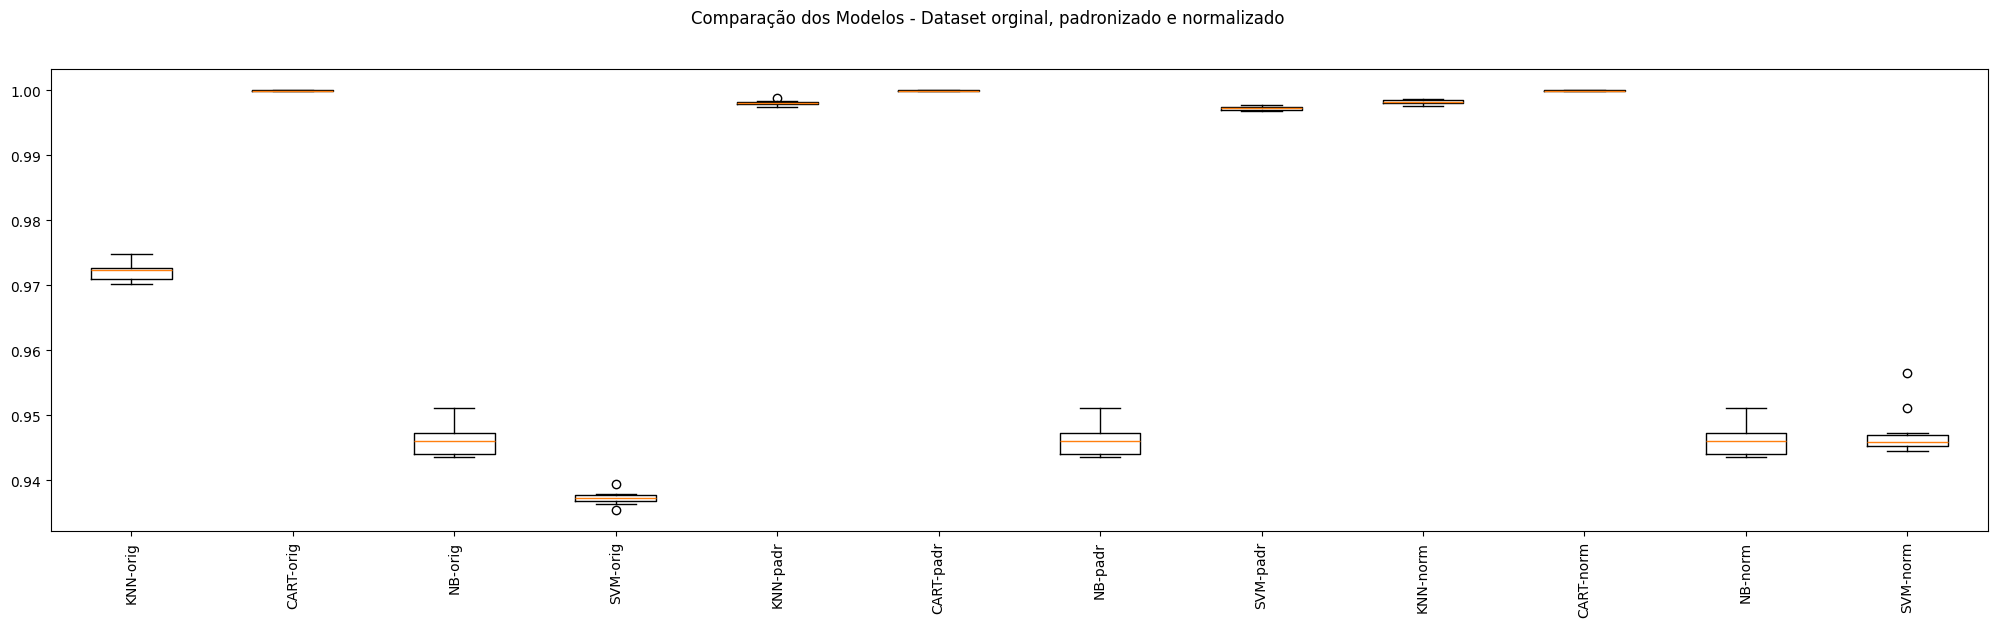

In [5]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Etapa 6: Otimização dos hiperparâmetros - Melhor Algoritmo: CART

In [6]:
# Pipeline para CART com padronização
pipeline = Pipeline([
    ('StandardScaler', StandardScaler()),
    ('CART', DecisionTreeClassifier())
])
pipelines.append(('CART-padr', pipeline))

# Definindo a grade de hiperparâmetros para otimização
param_grid = {
    'CART__max_depth': [3, 5, 7, 9, 11, None],
    'CART__min_samples_split': [2, 5, 10, 20],
    'CART__criterion': ['gini', 'entropy']
}

# Otimização com validação cruzada estratificada
grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kfold, scoring=scoring, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros e a acurácia correspondente
print(f"Melhor: {grid_result.best_score_:.4f} usando {grid_result.best_params_}")

Melhor: 0.9999 usando {'CART__criterion': 'entropy', 'CART__max_depth': 7, 'CART__min_samples_split': 5}


### Etapa 7: Finalização do Modelo

In [10]:
# Preparação do scaler com o conjunto de treino
scaler = StandardScaler().fit(X_train)
rescaledX_train = scaler.transform(X_train)
rescaledX_test = scaler.transform(X_test)

# Usa o melhor estimador encontrado pelo GridSearchCV
model = grid_result.best_estimator_
model.fit(rescaledX_train, y_train)

# Avaliação no conjunto de teste
predictions = model.predict(rescaledX_test)
print(accuracy_score(y_test, predictions))

0.99994


In [11]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

,steps,"[('StandardScaler', ...), ('CART', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,criterion,'entropy'
,splitter,'best'
,max_depth,7
,min_samples_split,5


### Etapa 8: Simulando a aplicação do modelo em dados não vistos

In [12]:
# Novos dados - não sabemos a classe!

# Dados de entrada para previsão
# 601.5229191365606,0.028723206008735267,0.8597786295284634,1.0,0.0,0.0,1.0,1.0 - fraud
# 4.057044416113516,2.142441467365621,0.3680000579792843,1.0,0.0,0.0,1.0,0.0 - normal
data = {
    'distance_from_home': [601.5229191365606, 4.057044416113516],
    'distance_from_last_transaction': [0.028723206008735267, 2.142441467365621],
    'ratio_to_median_purchase_price': [0.8597786295284634, 0.3680000579792843],
    'repeat_retailer': [1.0, 1.0],
    'used_chip': [0.0, 0.0],
    'used_pin_number': [0.0, 0.0],
    'online_order': [1.0, 0.0]
}

atributos = ['distance_from_home', 'distance_from_last_transaction',
             'ratio_to_median_purchase_price', 'repeat_retailer',
             'used_chip', 'used_pin_number', 'online_order']

entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:7].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 8.71175228 -0.21335233 -0.34154401  0.36643627 -0.73500612 -0.33386641
   0.73336722]
 [-0.34331792 -0.12373114 -0.51644129  0.36643627 -0.73500612 -0.33386641
  -1.36357335]]


In [13]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[1. 0.]


### Etapa 9: Exportando o modelo para o formato PKL

In [14]:
# Nome do arquivo para salvar o modelo
filename = 'credit_card_fraud_model.pkl'

# Salvar o modelo no arquivo
pickle.dump(model, open(filename, 'wb'))

print(f"Modelo exportado para '{filename}'")

Modelo exportado para 'credit_card_fraud_model.pkl'
